Install all libraries and prerequisites

In [11]:
!pip install absl-py
!pip install tensorflow
!pip install tensorflow-hub
!pip install seaborn
!pip install scikit-learn
!pip install torch
!pip install transformers datasets

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Load the libraries

In [12]:
# Normal packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

# Deep learning
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
from transformers import pipeline

# Scikit-learn (ML packages)
from sklearn.cluster import KMeans

# NLP
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk

In [4]:
# Download some nltk required data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Michael
[nltk_data]     Cortes\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to C:\Users\Michael
[nltk_data]     Cortes\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

Load the data

In [1]:
import pandas as pd

In [3]:
# Load the dataset for the drug reviews
df = pd.read_csv("drugLibTrain_raw.tsv", sep="\t")

# Look at its shape
df.shape

(3107, 9)

In [4]:
# Examine columns
df.sample(10)

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
3078,718,accutane,9,Highly Effective,Moderate Side Effects,acne,Clearing of acne.,"Headaches, dry lips, dry skin, elevated trigly...",Had severe cystic acne. Went to dermatologist...
1380,2326,lexapro,10,Considerably Effective,No Side Effects,depression,"I had hit the wall dealing with work, cllients...",The only side effect I believe is some weight ...,I take 1 lexapro daily. I have finished up wit...
2006,2142,concerta,9,Considerably Effective,Moderate Side Effects,add,"It allowed me to focus on what I was learning,...",The drug makes one sweat.It can work as an app...,I think that you can use a drug like this as a...
282,2077,metformin,9,Considerably Effective,Mild Side Effects,metabolic syndrome x,Reduced AM fasting glucose,"When first started taking the drug, patient ex...",Patient had almost all the markers for Metabol...
1321,1073,morphine,10,Considerably Effective,No Side Effects,post surgery extreme pain,"Relief of chronic intermittent pain. Also, rel...",No side effects even after prolonged use for i...,Currently being used on a as needed basis for ...
873,817,ambien,8,Highly Effective,Mild Side Effects,insomnia,The Ambien did give me a solid nights rest. I ...,After a while I seemed to notice that I was mi...,Not sure what this means. I was prescribed thi...
857,2603,ortho-tri-cyclen-lo,9,Highly Effective,Mild Side Effects,contraception,"the medicine was for contraceptive purposes, w...",The only side effects included breast tendines...,"I took one pill a day for 28 days, starting on..."
1718,4029,tri-luma,5,Moderately Effective,Moderate Side Effects,facial hyperpigmentation,"less acne, brown spots somewhat faded","redness, dryness\r\r\ncortisone-withdrawal ras...",daily application of cream to face
233,1284,provigil,4,Moderately Effective,Moderate Side Effects,anxiety and to avoid feeling misrable,none,"stomach bloating,tired feeling,hallucination a...","I have been using modafinil since 5 days, 100m..."
174,884,paxil,6,Considerably Effective,Severe Side Effects,depression,A more positive outlook and much easier social...,A total loss of any sexual sensation. Prior t...,Just the one pill each morning. This medicati...


Limit data to reviews we wish to build topics off of

In [30]:
# Look at the side effects only
sideEffectsReviews = df['sideEffectsReview'].dropna().tolist()

sideEffectsReviews

['cough, hypotension , proteinuria, impotence , renal failure , angina pectoris , tachycardia , eosinophilic pneumonitis, tastes disturbances , anusease anorecia , weakness fatigue insominca weakness',
 "Heavy Cycle, Cramps, Hot Flashes, Fatigue, Long Lasting Cycles. It's only been 5 1/2 months, but i'm concidering changing to a different bc. This is my first time using any kind of bc, unfortunately due to the constant hassel, i'm not happy with the results.",
 'Heavier bleeding and clotting than normal.',
 'Constipation, dry mouth and some mild dizziness that would go away after medication was stopped for a few days.',
 "I felt extremely drugged and dopey.  Could not drive at all while on this med.  Also had extreme ankle and feet swelling and couldn't even wear shoes.",
 'Low sex drive, before i started taking this drug i was 19 years of age and full of "enthousiasm". Now engaged and 21 years old, my sex drive is very low, my wife and I are very unsatisfied. I am also very tired even

Load the deep Learning NLP Models (pretrained)

In [32]:
# Universal Sentence Encoder Model
USE_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Sentiment model (from Hugging Face)
sentiment_model = pipeline("sentiment-analysis")

def embed(input):
    return np.array(USE_encoder(input))

def sentiment(input):
    result = sentiment_model(input)[0]
    sign = 1 if(result['label']=="POSITIVE") else -1
    return result['score'] * sign


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [33]:
embed(["I love cake."])

array([[ 0.03394474, -0.02648265,  0.03955458, -0.01104402,  0.0472017 ,
        -0.07641516, -0.05720296, -0.02907453,  0.0598927 ,  0.00589537,
         0.03063209, -0.03840635, -0.00262839,  0.05077115, -0.09602614,
        -0.05858866, -0.03548998,  0.03797373, -0.03417578, -0.04377306,
        -0.04776817,  0.0361936 ,  0.08292176,  0.0086083 ,  0.01019682,
        -0.04600836, -0.0348306 , -0.01528339, -0.00022703, -0.04680812,
        -0.04421519,  0.00129075, -0.03996844,  0.05841817, -0.0460149 ,
        -0.02596903, -0.00640805, -0.03435203, -0.07371631,  0.04830858,
         0.00969911,  0.04391295, -0.05914555,  0.035945  , -0.05920549,
         0.06323466, -0.04969632,  0.00170443,  0.07824276, -0.04943452,
        -0.00823305, -0.08116078, -0.01682351,  0.0381302 , -0.01284194,
        -0.03743605,  0.04715483, -0.03344095, -0.00319779,  0.00297234,
         0.02585401, -0.08517462,  0.00940963,  0.01192964,  0.01173826,
         0.07193531, -0.06327645, -0.01977318,  0.0

In [34]:
sentiment("I love cake.")

0.9998468160629272

Create topic model

In [86]:
class ReviewsTopicModel:

    STOPWORDS = stopwords.words('english')

    EMBEDDING_DIM = 512

    # Constructor
    def __init__(self, reviews):
        self.X = self.clean(reviews)


    def clean(self, reviews):
        # Clean words and strings
        string_map = {'\r': '', '\n': '', }
        reviews_cleaned = reviews[:]
        for i in range(len(reviews_cleaned)):
            for s in string_map:
                reviews_cleaned[i] = reviews_cleaned[i].replace(s, string_map[s]).lower()

        # Transform into embeddings
        X = embed(reviews_cleaned) # n x 512 matrix
        X = pd.DataFrame(X)
        X.index = reviews_cleaned
        return X


    def create_topics(self, num_topics):
        # Cluster reviews
        kmeans = KMeans(n_clusters=num_topics)
        kmeans.fit(self.X)

        # Create the final topics dataframe
        self.topics_df = self.X.copy()
        self.topics_df['topic'] = kmeans.labels_.copy() # assign topic labels
        self.topics_df['topic'] = self.topics_df['topic'].astype(int) # enforce topics to be integers

        # Create summary keywords
        self.topic_keywords = {}
        for topic in self.topics_df['topic'].unique():
            topic_reviews = self.topics_df.query("topic == {}".format(topic)).drop(columns=['topic']).index.tolist()
            topic_centroid = kmeans.cluster_centers_[topic]
            self.topic_keywords[topic] = self.get_closest_words(topic_reviews, topic_centroid)
        self.topics_df['topic_keywords'] = self.topics_df['topic'].map(self.topic_keywords)

        # Score sentiment of sentences

        # Trim down topics dataframe to remove the embedding columns
        self.topics_df = self.topics_df[['topic', 'topic_keywords']]


    def get_closest_words(self, reviews, centroid):
        word_distances = {}
        for r in reviews:
            review_words = [w for w in word_tokenize(r) if(w not in self.STOPWORDS)]
            for w in review_words:
                if(w not in word_distances):
                    word_embedding = embed([w])
                    # calculate cosine similarity
                    word_distances[w] = self.cosine_similarity(word_embedding, centroid)
        word_distances = sorted([(word_distances[w], w) for w in word_distances])[-5:]
        return ",".join([x[1] for x in word_distances])

    def cosine_similarity(self, x, y):
        x = x.reshape(self.EMBEDDING_DIM,)
        y = y.reshape(self.EMBEDDING_DIM,)
        dotproduct = x.dot(y)
        x_magnitude = x.dot(x)**0.5
        y_magnitude = y.dot(y)**0.5
        return dotproduct/(x_magnitude * y_magnitude)


    def elbow_plot(self, max_topics=10):
        cluster_sizes = list(range(1,max_topics+1))
        scores = []
        for n in cluster_sizes:
            kmeans = KMeans(n_clusters=n)
            kmeans.fit(self.X)
            scores.append(kmeans.inertia_)
        plt.figure()
        plt.plot(cluster_sizes, scores)
        plt.show()




Initialize Topic Model

In [87]:
topic_model = ReviewsTopicModel(sideEffectsReviews)


Create elbow plot to determine optimal number of topics (i.e. clusters)

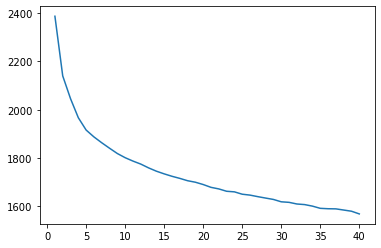

In [55]:

topic_model.elbow_plot(40)

Create final model and evaluate

In [97]:
# Fit final topic model
topic_model.create_topics(num_topics = 30)

In [103]:
select_topic = 20
print(topic_model.topic_keywords[select_topic])
topic_model.topics_df.query("topic == {}".format(select_topic))

swelling,pounds,fat,gaining,weight


,topic,topic_keywords
has gained quite abit of weight but as he has had problems gaining weight since being a toddler this isnt a bad thing,20,"swelling,pounds,fat,gaining,weight"
"nightmares, some drowsiness during the day, minor weight gain",20,"swelling,pounds,fat,gaining,weight"
severe appetite loss and some weight loss.,20,"swelling,pounds,fat,gaining,weight"
"slight weight gain, and a bit(not too much) sleepier.",20,"swelling,pounds,fat,gaining,weight"
"weight gain, which is to be expected when you ""feel better""",20,"swelling,pounds,fat,gaining,weight"
"extreme drowsiness, weight gain.",20,"swelling,pounds,fat,gaining,weight"
weight gain,20,"swelling,pounds,fat,gaining,weight"
weight gain from taking the med,20,"swelling,pounds,fat,gaining,weight"
"thirst, tremor, slight weight gain, occassional nausea",20,"swelling,pounds,fat,gaining,weight"
some weight gain,20,"swelling,pounds,fat,gaining,weight"
